In [5]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as l
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Fashion MNIST Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = tf.cast(x_train, tf.float32) / 255.
x_test = tf.cast(x_test, tf.float32) / 255.
y_train_cat = keras.utils.to_categorical(y_train, num_classes=10)
y_test_cat =  keras.utils.to_categorical(y_test, num_classes=10)

In [7]:
# Simple Classifier
def make_simple_classifier():
    inputs = l.Input(shape=(28,28,1))
    z = l.Flatten()(inputs)
    z = l.Dense(200, activation='relu')(z)
    z = l.Dense(100, activation='relu')(z)
    output = l.Dense(10, activation='softmax')(z)
    
    return keras.Model(inputs=[inputs], outputs=[output])
    

In [13]:
simple_clf = make_simple_classifier()
simple_clf.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-3), metrics=['accuracy'])
history = simple_clf.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=1)

1875/1875 [==============================] - 6s 3ms/step - loss: 0.4814 - accuracy: 0.8252 - val_loss: 0.3999 - val_accuracy: 0.8541


# Custom Callbacks

#### Make a class that subclasses the keras.callbacks.Callback class and override a set of methods that are called at different points during fit/evaluate/predict

In [18]:
# Reference: https://keras.io/guides/writing_your_own_callbacks/
class MyCustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting Training. Got Log Keys: {}".format(keys))
    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Finished Training. Got Log Keys: {}".format(keys))

In [19]:
simple_clf = make_simple_classifier()
simple_clf.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-3), metrics=['accuracy'])
history = simple_clf.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=1, callbacks=[MyCustomCallback()])

Starting Training. Got Log Keys: []
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4824 - accuracy: 0.8262 - val_loss: 0.4194 - val_accuracy: 0.8489
Finished Training. Got Log Keys: ['loss', 'accuracy', 'val_loss', 'val_accuracy']


#### The logs dict contains the loss value and all the metrics at the end of a back or epoch

#### Custom Callbacs also have access to the model, using self.model. We can use this to stop training, change weights, save the model at intervals, visualize features over time, and monitor the value of predict at intermediate points, along with other things.

#### Lets make an autoencoder and monitor the progression of outputs overtime as it trains

### Autoencoder Creation

In [34]:
def create_simple_ae():
    inputs = l.Input(shape=(28,28,1))
    z = l.Flatten()(inputs)
    z = l.Dense(200, activation='relu')(z)
    z = l.Dense(100, activation='relu')(z)
    z = l.Dense(10, activation='relu')(z)
    z = l.Dense(100, activation='relu')(z)
    z = l.Dense(200, activation='relu')(z)
    z = l.Dense(28*28, activation='relu')(z)
    output = l.Reshape((28,28,1))(z)
    
    return keras.Model(inputs=[inputs], outputs=[output]) 

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
def show_reconstruction(model, images, multi_output=False):
    n_images = len(images)
    #reconstructions = model.predict(test.take(n_images))
    fig = plt.figure(figsize=(n_images*1.5, 3))
    for img_index, img in enumerate(images):
        reconstruction = model.predict(tf.reshape(img, (1,28,28,1)))
        plt.subplot(2, n_images, 1 + img_index)
        plot_image(img)
        plt.subplot(2, n_images, 1 + img_index + n_images)
        if multi_output:
            plot_image(reconstruction[0][0])
        else:
            plot_image(reconstruction[0])

In [39]:
simple_ae = create_simple_ae()
simple_ae.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-3), metrics=['MAE'])
history = simple_ae.fit(x_train, x_train, epochs=1)

1875/1875 [==============================] - 11s 6ms/step - loss: 0.0373 - MAE: 0.0995


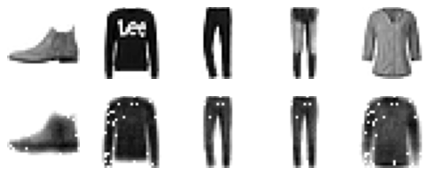

In [40]:
show_reconstruction(simple_ae, x_test[:5])

### Custom Callback to monitor indermediate images

In [49]:
class PlotIntermidiateOutputs(keras.callbacks.Callback):
    def __init__(self, n_images=1):
        super().__init__()
        self.n_images = n_images
    
    def on_epoch_end(self, epoch, logs=None):
        print("Current Output for epoch {}".format(epoch))
        show_reconstruction(self.model, x_test[:self.n_images])
        plt.show()
    

Epoch 1/5
1866/1875 [============================>.] - ETA: 0s - loss: 0.0338 - MAE: 0.0947Current Output for epoch 0


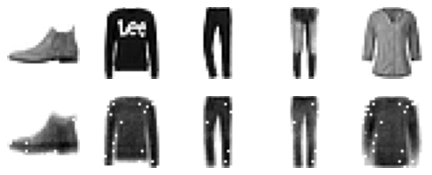

1875/1875 [==============================] - 11s 6ms/step - loss: 0.0338 - MAE: 0.0946
Epoch 2/5
1868/1875 [============================>.] - ETA: 0s - loss: 0.0217 - MAE: 0.0749Current Output for epoch 1


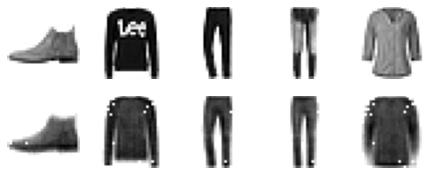

1875/1875 [==============================] - 12s 6ms/step - loss: 0.0217 - MAE: 0.0749
Epoch 3/5
1875/1875 [==============================] - ETA: 0s - loss: 0.0202 - MAE: 0.0717Current Output for epoch 2


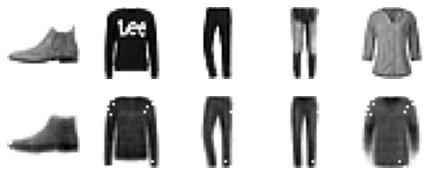

1875/1875 [==============================] - 11s 6ms/step - loss: 0.0202 - MAE: 0.0717
Epoch 4/5
1869/1875 [============================>.] - ETA: 0s - loss: 0.0195 - MAE: 0.0699Current Output for epoch 3


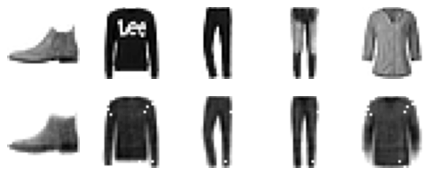

1875/1875 [==============================] - 11s 6ms/step - loss: 0.0195 - MAE: 0.0700
Epoch 5/5
1868/1875 [============================>.] - ETA: 0s - loss: 0.0190 - MAE: 0.0689Current Output for epoch 4


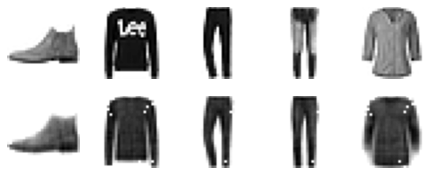

1875/1875 [==============================] - 11s 6ms/step - loss: 0.0190 - MAE: 0.0689


In [52]:
simple_ae = create_simple_ae()
simple_ae.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-3), metrics=['MAE'])
history = simple_ae.fit(x_train, x_train, epochs=5, callbacks=[PlotIntermidiateOutputs(5)])